In [0]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
drive_link = "/content/drive/My Drive/Colab Notebooks/HAR/"

In [0]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [0]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [0]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'{drive_link}UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [0]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'{drive_link}UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [0]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [0]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

In [0]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [11]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [0]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [0]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

In [0]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [15]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [16]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


- Defining the Architecture of LSTM

In [38]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [40]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 28s 4ms/step - loss: 1.3261 - acc: 0.4374 - val_loss: 1.1536 - val_acc: 0.4798
Epoch 2/30
7352/7352 [==============================] - 27s 4ms/step - loss: 0.9782 - acc: 0.5752 - val_loss: 0.9710 - val_acc: 0.5881
Epoch 3/30
7352/7352 [==============================] - 27s 4ms/step - loss: 0.7828 - acc: 0.6527 - val_loss: 0.7607 - val_acc: 0.6203
Epoch 4/30
7352/7352 [==============================] - 27s 4ms/step - loss: 0.6914 - acc: 0.6717 - val_loss: 0.8030 - val_acc: 0.6261
Epoch 5/30
7352/7352 [==============================] - 27s 4ms/step - loss: 0.6321 - acc: 0.7127 - val_loss: 0.7291 - val_acc: 0.7180
Epoch 6/30
7352/7352 [==============================] - 27s 4ms/step - loss: 0.5658 - acc: 0.7508 - val_loss: 0.7274 - val_acc: 0.7150
Epoch 7/30
7352/7352 [==============================] - 27s 4ms/step - loss: 0.5461 - acc: 0.7816 - val_loss: 0.5893 - val_acc: 0.7506
Epoch 8

In [41]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  ...  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                 ...                                      
LAYING                 510        0  ...                   0                 0
SITTING                  0      408  ...                   1                 1
STANDING                 0      103  ...                   0                 1
WALKING                  0        0  ...                  16                11
WALKING_DOWNSTAIRS       0        0  ...                 391                26
WALKING_UPSTAIRS         0        0  ...                  12               449

[6 rows x 6 columns]


In [42]:
score = model.evaluate(X_test, Y_test)
print(score)

2947/2947 [==============================] - 1s 304us/step
[0.4573536882557054, 0.9005768578417389]


In [0]:
#Lets reduce dropout and check the results

In [44]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim), kernel_initializer="glorot_normal"))
# Adding a dropout layer
model.add(Dropout(0.25))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [46]:
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=64,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 10s 1ms/step - loss: 1.4846 - acc: 0.3791 - val_loss: 1.3259 - val_acc: 0.4377
Epoch 2/30
7352/7352 [==============================] - 9s 1ms/step - loss: 1.1755 - acc: 0.5203 - val_loss: 1.1487 - val_acc: 0.4975
Epoch 3/30
7352/7352 [==============================] - 9s 1ms/step - loss: 1.0680 - acc: 0.5409 - val_loss: 1.1269 - val_acc: 0.4432
Epoch 4/30
7352/7352 [==============================] - 9s 1ms/step - loss: 1.0095 - acc: 0.5301 - val_loss: 1.0349 - val_acc: 0.5470
Epoch 5/30
7352/7352 [==============================] - 9s 1ms/step - loss: 0.9016 - acc: 0.5819 - val_loss: 0.9898 - val_acc: 0.5680
Epoch 6/30
7352/7352 [==============================] - 9s 1ms/step - loss: 0.9225 - acc: 0.5665 - val_loss: 0.9704 - val_acc: 0.5382
Epoch 7/30
7352/7352 [==============================] - 9s 1ms/step - loss: 0.9060 - acc: 0.5778 - val_loss: 0.9698 - val_acc: 0.5378
Epoch 8/30
73

In [47]:
score = model.evaluate(X_test, Y_test)
print(score)

2947/2947 [==============================] - 1s 301us/step
[0.612743710102289, 0.7960637936884968]


In [48]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  ...  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                 ...                                      
LAYING                 510        0  ...                   0                27
SITTING                  1      397  ...                   0                23
STANDING                 0       91  ...                   1                23
WALKING                  1        1  ...                  57               107
WALKING_DOWNSTAIRS       0        0  ...                 264               135
WALKING_UPSTAIRS         3        2  ...                  16               442

[6 rows x 6 columns]


In [0]:
import matplotlib.pyplot as plt

# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

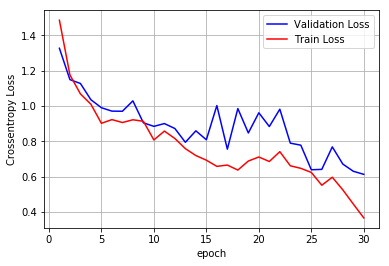

In [50]:

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [0]:
#lets increase the LSTM units and check the results

In [17]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(64, input_shape=(timesteps, input_dim), kernel_initializer="glorot_normal"))
# Adding a dropout layer
model.add(Dropout(0.25))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                18944     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 390       
Total params: 19,334
Trainable params: 19,334
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Compiling the model
model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [19]:
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=64,
          validation_data=(X_test, Y_test),
          epochs=epochs)



Train on 7352 samples, validate on 2947 samples
Epoch 1/30




7352/7352 [==============================] - 16s 2ms/step - loss: 0.4314 - acc: 0.8407 - val_loss: 0.4405 - val_acc: 0.8571
Epoch 2/30
7352/7352 [==============================] - 15s 2ms/step - loss: 0.3934 - acc: 0.8455 - val_loss: 0.4029 - val_acc: 0.8215
Epoch 3/30
7352/7352 [==============================] - 15s 2ms/step - loss: 0.3790 - acc: 0.8472 - val_loss: 0.3532 - val_acc: 0.8613
Epoch 4/30
7352/7352 [==============================] - 15s 2ms/step - loss: 0.3122 - acc: 0.8705 - val_loss: 0.3097 - val_acc: 0.8715
Epoch 5/30
7352/7352 [==============================] - 15s 2ms/step - loss: 0.2996 - acc: 0.8672 - val_loss: 0.4036 - val_acc: 0.8418
Epoch 6/30
7352/7352 [==============================] - 15s 2ms/step - loss: 0.3114 - acc: 0.8606 - val_loss: 0.2760 - val_acc: 0.8821
Epoch 7/30
7352/7352 [==============================] - 15s 2ms/step - loss: 0.2624 - acc: 0.8876 - val_loss: 0.3487 - val_acc: 0.8682
E

In [20]:

score = model.evaluate(X_test, Y_test)
print(score)

2947/2947 [==============================] - 1s 451us/step
[0.1906922204002187, 0.9098518366404295]


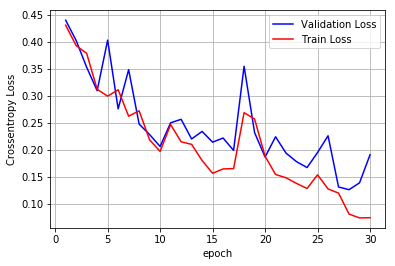

In [23]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [0]:
#Lets add one more LSTM layer use rsmprop as optimizer and check the accuracy 

In [58]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(64, input_shape=(timesteps, input_dim), kernel_initializer="glorot_normal", return_sequences = True))
# Adding a dropout layer
model.add(Dropout(0.25))
model.add(LSTM(n_hidden))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 128, 64)           18944     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128, 64)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 198       
Total params: 31,558
Trainable params: 31,558
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compiling the model
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [60]:
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=64,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 28s 4ms/step - loss: 0.3685 - acc: 0.8558 - val_loss: 0.3627 - val_acc: 0.8646
Epoch 2/30
7352/7352 [==============================] - 26s 4ms/step - loss: 0.2619 - acc: 0.8847 - val_loss: 0.2689 - val_acc: 0.8828
Epoch 3/30
7352/7352 [==============================] - 26s 4ms/step - loss: 0.2217 - acc: 0.8981 - val_loss: 0.2119 - val_acc: 0.9028
Epoch 4/30
7352/7352 [==============================] - 27s 4ms/step - loss: 0.1941 - acc: 0.9169 - val_loss: 0.2061 - val_acc: 0.9072
Epoch 5/30
7352/7352 [==============================] - 26s 4ms/step - loss: 0.1804 - acc: 0.9228 - val_loss: 0.1808 - val_acc: 0.9235
Epoch 6/30
7352/7352 [==============================] - 26s 4ms/step - loss: 0.1559 - acc: 0.9407 - val_loss: 0.1631 - val_acc: 0.9363
Epoch 7/30
7352/7352 [==============================] - 26s 4ms/step - loss: 0.1272 - acc: 0.9578 - val_loss: 0.1360 - val_acc: 0.9522
Epoch 8

In [61]:

score = model.evaluate(X_test, Y_test)
print(score)

2947/2947 [==============================] - 2s 789us/step
[0.0947089619885832, 0.9693473638580499]


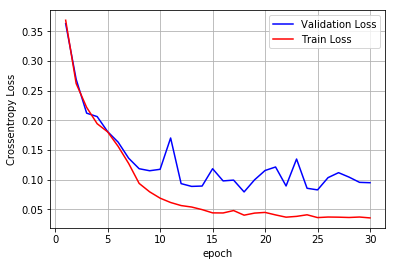

In [62]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

# Conclusion:

In [24]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model","Lstm Units","Dropout","Optimizer","Accuracy"]

x.add_row(["Lstm","32","0.5","rmsprop" ,"0.9005"])
x.add_row(["Lstm","32",".25","rmsprop" ,"0.7960"])
x.add_row(["Lstm","64",".25" ,"Adam", "0.9098"])
x.add_row(["Lstm","64",".25","rmsprop" ,"0.9693"])


print(x)

+-------+------------+---------+-----------+----------+
| Model | Lstm Units | Dropout | Optimizer | Accuracy |
+-------+------------+---------+-----------+----------+
|  Lstm |     32     |   0.5   |  rmsprop  |  0.9005  |
|  Lstm |     32     |   .25   |  rmsprop  |  0.7960  |
|  Lstm |     64     |   .25   |    Adam   |  0.9098  |
|  Lstm |     64     |   .25   |  rmsprop  |  0.9693  |
+-------+------------+---------+-----------+----------+


  Increasing Lstm units and decreasing dropouts returns good accuracy.

  With Lstm(64 units) + dropout(0.25)+ optimizer(rmsprop) able to achieve test acccuracy of 96.93%.